<h3> Create and Save a Barscan Calibration</h3>

Most relevant function here is [calculate_barscan_calibration](http://docs.drt-sans.ornl.gov/drtsans/pixel_calibration.html#drtsans.pixel_calibration.calculate_barscan_calibration).

The output of <code>calculate_barscan_calibration</code> outputs an object containing two parts: a <b>metadata</b> (instrument name, day stamp, name of the double-detector-array), and the proper calibration data, contained in a Mantid <b>table</b> object.

In [ ]:
#
# "plot_workspace" is a utility function, which we will use a couple of times
#
from drtsans.plots import plot_detector
def plot_workspace(input_workspace, axes_mode='tube-pixel'):
    return plot_detector(input_workspace, backend='mpl',axes_mode=axes_mode, imshow_kwargs={})

The barscan file we'll use (CG2_7465.nxs.h5) contains a full barscan with 110 different positions for the bar.

In [ ]:
import os
import time
from drtsans.pixel_calibration import calculate_barscan_calibration

data_dir = '/HFIR/CG2/shared/sans-backend/data/new/ornl/sans/hfir/gpsans/pixel_calibration'
barscan_file = os.path.join(data_dir, 'CG2_7465.nxs.h5')  # absolute path to the file

start_time = time.time()
calibration = calculate_barscan_calibration(barscan_file)  # calibration for array 'detector1'
print('Calibration took ', int((time.time() - start_time) / 60), 'minutes')

<h5>Calibration objects are saved to a database as two separate pieces:</h5>

- metadata (instrument name, day stamp, name of the double-detector-array) is save to a JSON file.  
- data (a table workspace) is saved to a Nexus file with SaveNexus.  

There's a default database for every instrument. The GPSANS location for the metadata JSON file:

- GPSANS: <b>/HFIR/CG2/shared/calibration/pixel_calibration.json</b>

Data tables are saved under `tables/` subdirectory:

- GPSANS: <b>/HFIR/CG2/shared/calibration/tables</b>

<h5>Calibration objects have method "<b>save</b>" to save itself to the the database. The full signature of this method:</h5>

    def save(self, database=None, tablefile=None, overwrite=False):
        r"""
        Save the calibration metadata in a JSON file, and the calibration table workspace in a Nexus file.

        Parameters
        ----------
        database: str
            Path to the JSON file where the ```metadata``` dictionary will be appended. If :py:obj:`None`,
            then the appropriate default file from ~drtsans.pixel_calibration.database_file is used.
            Currently, these are the default files:
            - BIOSANS, '/HFIR/CG3/shared/calibration/pixel_calibration.json',
            - EQSANS, '/SNS/EQSANS/shared/calibration/pixel_calibration.json',
            - GPSANS, '/HFIR/CG2/shared/calibration/pixel_calibration.json'
        tablefile: str
            Path to the Nexus file storing the pixel calibration data. If :py:obj:`None`, then
            a composite name is created using the calibration type, instrument, component,
            and daystamp. (e.g. "barscan_gpsans_detector1_20200311"). The file is saved under
            subdirectory 'tables', located within the directory of the ```database``` file.
            For instance, '/HFIR/CG3/shared/calibration/tables/barscan_gpsans_detector1_20200311.nxs'
        overwrite: bool
            Substitute existing entry with same metadata

        Raises
        ------
        ValueError
            If we save a calibration already in the database with option ```overwrite=False```.
        """

In [ ]:
# Notice we overwrite the already saved calibration, which will happen if we run this notebook more than once.
calibration.save(overwrite=True)

<h3>Load and Apply a Barscan Calibration</h3>

Most relevant function is [load_calibration](http://docs.drt-sans.ornl.gov/drtsans/pixel_calibration.html#drtsans.pixel_calibration.load_calibration)

In [ ]:
import os
from mantid.simpleapi import LoadNexus
from drtsans.pixel_calibration import load_calibration

# "plot_workspace" is a utility function, which we will use a couple of times
from drtsans.plots import plot_detector
def plot_workspace(input_workspace, axes_mode='tube-pixel'):
    return plot_detector(input_workspace, backend='mpl',axes_mode=axes_mode, imshow_kwargs={})

Below we load the run to which we will apply the calibration. It is one of the scans, with the bar positioned past the middle of the detector.  
We take a look by plotting the pixel intensities on the main detector.

In [ ]:
# Load the run to which we will apply the calibration
data_dir = '/HFIR/CG2/shared/sans-backend/data/new/ornl/sans/hfir/gpsans/pixel_calibration'
LoadNexus(os.path.join(data_dir, 'scan_88.nxs'), OutputWorkspace='scan_88')

plot_detector('scan_88', axes_mode='xy')

Notice in the previous plot some spikes in the shadow cast by the bar. The spikes indicate tubes that need badly to be calibrated.

Loading a calibration with [load_calibration](http://docs.drt-sans.ornl.gov/drtsans/pixel_calibration.html#drtsans.pixel_calibration.load_calibration) requires at least a target workspace and the type of calibration to be loaded. This functions return a calibration object.

The calibration object has method <b>apply</b> to apply itself into a target workspace. Here's the full documentation for this method:

    def apply(self, input_workspace, output_workspace=None):
        r"""
        Apply a calibration to an input workspace, and return the calibrated workspace.

        Parameters
        ----------
        input_workspace: str, ~mantid.api.MatrixWorkspace, ~mantid.api.IEventsWorkspace
            Workspace to which calibration needs to be applied.
        output_workspace: str
            Name of the output workspace with calibrated pixels. If :py:obj:`None`, the pixels
            of the input workspace will be calibrated and no new workspace is generated.

        Returns
        -------
        ~mantid.api.MatrixWorkspace, ~mantid.api.IEventsWorkspace
        """

In [ ]:
calibration = load_calibration('scan_88', 'BARSCAN')
# Apply the calibration.
start_time = time.time()
calibration.apply('scan_88')
print(f'Applying the calibration took {time.time() - start_time:.1} seconds')

Again we plot the pixel intensities on the main detector and visually compare to the previous plot.

In [ ]:
plot_detector('scan_88', axes_mode='xy')

In the calibrated workpace, the shadow spikes have been considerably supressed.

<h3>Calculate Tube Width Calibration</h3>

Relevant function is [calculate_apparent_tube_width](http://docs.drt-sans.ornl.gov/drtsans/pixel_calibration.html#drtsans.pixel_calibration.calculate_apparent_tube_width)

In [ ]:
from mantid.simpleapi import LoadEventNexus, Rebin
from drtsans.pixel_calibration import calculate_apparent_tube_width

#
# "plot_workspace" is a utility function, which we will use a couple of times
#
from drtsans.plots import plot_detector
def plot_workspace(input_workspace, axes_mode='tube-pixel'):
    return plot_detector(input_workspace, backend='mpl',axes_mode=axes_mode, imshow_kwargs={})

The flood file CG2_8143.nxs.h5 is 1.6GB in size. We don't need the events, but only the total intensity per pixel, so we convert to a matrix workspace and keep only one bin.

In [ ]:
flood_file = '/HFIR/CG2/IPTS-23801/nexus/CG2_8143.nxs.h5'
LoadEventNexus(Filename='/HFIR/CG2/IPTS-23801/nexus/CG2_8143.nxs.h5', OutputWorkspace='flood_workspace')
# Rebins all events between TOF=0 and TOF=10^6 micro-seconds into a single bin
Rebin(InputWorkspace='flood_workspace', OutputWorkspace='flood_workspace',
      Params=[0, 1.E06, 1.E06], PreserveEvents=False)

plot_workspace('flood_workspace')

Ideally, calculation of the apparent tube width requires that the pixel positions and heights have been calibrated with a barscan. If no good barscan is present in the database, we can use the default pixel positions and heights defined in the instrument defintion file by setting <code>load_barscan_calibration=False</code>

In [ ]:
start_time = time.time()
calibration = calculate_apparent_tube_width('flood_workspace')
print('Calibration took ', int(time.time() - start_time), 'seconds')

<h5>Calibration objects are saved to a database as two separate pieces:</h5>

- metadata (instrument name, day stamp, name of the double-detector-array) is save to a JSON file.  
- data (a table workspace) is saved to a Nexus file with SaveNexus.  

There's a default database for every instrument. The GPSANS location for the metadata JSON file:

- GPSANS: <b>/HFIR/CG2/shared/calibration/pixel_calibration.json</b>

Data tables are saved under `tables/` subdirectory:

- GPSANS: <b>/HFIR/CG2/shared/calibration/tables</b>

<h5>Calibration objects have method "<b>save</b>" to save itself to the the database. The full signature of this method:</h5>

    def save(self, database=None, tablefile=None, overwrite=False):
        r"""
        Save the calibration metadata in a JSON file, and the calibration table workspace in a Nexus file.

        Parameters
        ----------
        database: str
            Path to the JSON file where the ```metadata``` dictionary will be appended. If :py:obj:`None`,
            then the appropriate default file from ~drtsans.pixel_calibration.database_file is used.
            Currently, these are the default files:
            - BIOSANS, '/HFIR/CG3/shared/calibration/pixel_calibration.json',
            - EQSANS, '/SNS/EQSANS/shared/calibration/pixel_calibration.json',
            - GPSANS, '/HFIR/CG2/shared/calibration/pixel_calibration.json'
        tablefile: str
            Path to the Nexus file storing the pixel calibration data. If :py:obj:`None`, then
            a composite name is created using the calibration type, instrument, component,
            and daystamp. (e.g. "barscan_gpsans_detector1_20200311"). The file is saved under
            subdirectory 'tables', located within the directory of the ```database``` file.
            For instance, '/HFIR/CG3/shared/calibration/tables/barscan_gpsans_detector1_20200311.nxs'
        overwrite: bool
            Substitute existing entry with same metadata

        Raises
        ------
        ValueError
            If we save a calibration already in the database with option ```overwrite=False```.
        """

In [ ]:
# Notice we overwrite the already saved calibration, which will happen if we run this notebook more than once.
calibration.save(overwrite=True)

<h3>Load and Apply a Tube Width Calibration</h3>

First some general imports and a couple of custom plotting functions

In [11]:
from mantid.api import mtd
from mantid.simpleapi import CreateWorkspace, LoadNexus
from drtsans.pixel_calibration import load_calibration
from drtsans.tubecollection import TubeCollection

#
# "plot_workspace" is a utility function, which we will use a couple of times
#
from drtsans.plots import plot_detector
def plot_workspace(input_workspace, axes_mode='tube-pixel'):
    return plot_detector(input_workspace, backend='mpl',axes_mode=axes_mode, imshow_kwargs={})

#
# "plot_histograms" to create fancy plots of the spectram stored in an input workspace
#
def plot_histograms(input_workspace, legend=[], xlabel='X-axis', ylabel='Y-axis', title='', linewidths=[]):
    r"""Line plot for the histograms of a workspace"""
    workspace = mtd[str(input_workspace)]
    number_histograms = workspace.getNumberHistograms()
    if len(legend) != number_histograms:
        legend = [str(i) for i in range(number_histograms)]
    if len(linewidths) != number_histograms:
        linewidths = [1] * number_histograms
    fig, ax = plt.subplots(subplot_kw={'projection':'mantid'})
    for workspace_index in range(number_histograms):
        ax.plot(workspace, wkspIndex=workspace_index, label=legend[workspace_index],
                linewidth=linewidths[workspace_index])
    ax.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.tick_params(axis='x', direction='in')
    ax.tick_params(axis='y', direction='out')
    ax.grid(True)
    fig.show()

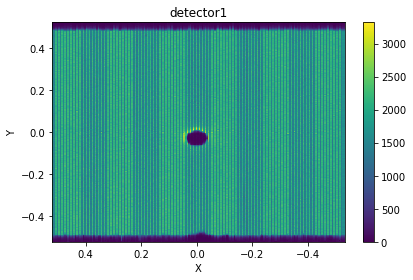

In [6]:
# Load the run to which we will apply the calibration, then plot the pixel intensities
input_data = '/HFIR/CG2/IPTS-23801/nexus/CG2_8143.nxs.h5'
LoadEventNexus(Filename='/HFIR/CG2/IPTS-23801/nexus/CG2_8143.nxs.h5', OutputWorkspace='workspace')

plot_workspace('workspace', axes_mode='xy')

The run corresponds to a flood run.

<h4>Intensities Normalized by Pixel Width</h4>
In function <code>linear_density</code> we integrate the total intensity per tube and divide by the tube width. Front end tubes collect more intentity than the back tubes. Similarly, front end tubes have a larger apparent tube width than back tubes. The ratio of total intensity to width should be similar for front and end tubes after the calibration.

In [7]:
def linear_density(workspace):
    r"""Tube total intensity per unit length of tube width"""
    collection = TubeCollection(workspace, 'detector1').sorted(view='decreasing X')
    intensities = np.array([np.sum(tube.readY) for tube in collection])
    widths = np.array([tube[0].width for tube in collection])
    return list(intensities / widths)

uncalibrated_densities = linear_density('workspace')

We store both linear densities in a workspace, and then we'll use matplotlib to plot both densities.

Most relevant function is [load_calibration](http://docs.drt-sans.ornl.gov/drtsans/pixel_calibration.html#drtsans.pixel_calibration.load_calibration)

In [12]:
start_time = time.time()
calibration = load_calibration('workspace', 'TUBEWIDTH')
calibration.apply('workspace')
print('Applying the calibration took ', time.time() - start_time, 'seconds')

calibrated_densities = linear_density('workspace')

Applying the calibration took  0.12635564804077148 seconds


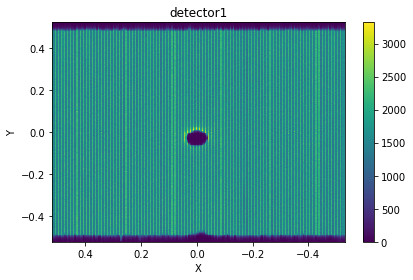

In [13]:
plot_workspace('workspace', axes_mode='xy')

We store both linear densities in a workspace, and then we'll use matplotlib to plot both densities

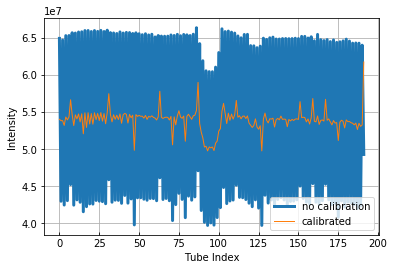

In [14]:
number_tubes = len(uncalibrated_densities)
CreateWorkspace(DataX=range(number_tubes),
                DataY=np.array([uncalibrated_densities, calibrated_densities]),
                NSpec=2,   # two histograms
                Outputworkspace='linear_densities')
plot_histograms('linear_densities',
                legend=['no calibration', 'calibrated'],
                xlabel='Tube Index', ylabel='Intensity', linewidths=[3, 1])

The oslillating intensities in the linear densities have been suppresed for most tubes, indicating the calibration is working.

<h3>Loading and Applying a pixel calibration</h3>

Relevant function is [apply_calibrations](http://docs.drt-sans.ornl.gov/drtsans/pixel_calibration.html#drtsans.pixel_calibration.apply_calibrations), which will search for <code>BARSCAN</code> and <code>TUBEWIDTH</code> calibrations appropriate to the target run

In [1]:
import time
from mantid.simpleapi import LoadEventNexus
from drtsans.pixel_calibration import apply_calibrations

#
# "plot_workspace" is a utility function, which we will use a couple of times
#
from drtsans.plots import plot_detector
def plot_workspace(input_workspace, axes_mode='tube-pixel'):
    return plot_detector(input_workspace, backend='mpl',axes_mode=axes_mode, imshow_kwargs={})

/home/jbq/.virtualenvs/sans-backend4/lib/python3.6/site-packages/h5py/__init__.py:72: UserWarning: h5py is running against HDF5 1.10.0 when it was built against 1.10.2, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


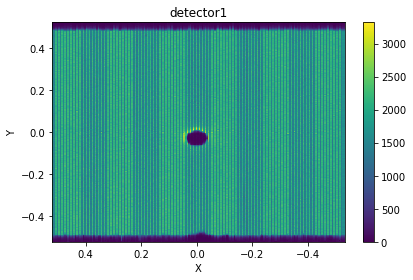

In [2]:
# Load the run to which we will apply the calibration, then plot the pixel intensities
input_data = '/HFIR/CG2/IPTS-23801/nexus/CG2_8143.nxs.h5'
LoadEventNexus(Filename='/HFIR/CG2/IPTS-23801/nexus/CG2_8143.nxs.h5', OutputWorkspace='workspace')

plot_workspace('workspace', axes_mode='xy')

In [3]:
start_time = time.time()
apply_calibrations('workspace')
print('Applying the calibration took ', time.time() - start_time, 'seconds')

Applying the calibration took  0.32411646842956543 seconds


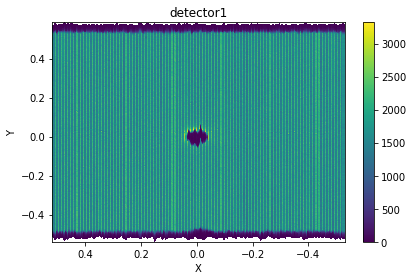

In [4]:
plot_workspace('workspace', axes_mode='xy')

The calibration makes things worse, but this is because the barscan that determined the calibration was taken at a time when the tubes behaved quite differently that the time when the input data was taken. This is a clear sign that <b>a new barscan is needed</b>.

We can see when the BARSCAN calibration was taken, and the time when the input data was taken. For this we use function [load_calibration](http://docs.drt-sans.ornl.gov/drtsans/pixel_calibration.html#drtsans.pixel_calibration.load_calibration) and function <code>day_stamp</code>.

In [ ]:
from drtsans.pixel_calibration import load_calibration, day_stamp
calibration = load_calibration('workspace', 'BARSCAN')
print('BARSCAN taken on', calibration.daystamp)
print('Input data taken on ', day_stamp('workspace'))